In [10]:
import pandas as pd
from memo import memo
import jax
import jax.numpy as np
from enum import IntEnum, auto
# read in files
# Read UK_df.csv as pandas dataframe
original_UK_dialogue = pd.read_csv('UK_df.csv')
original_UK_politeness = pd.read_csv('UK_direct_df.csv')
original_UK_narrator = pd.read_csv('UK_narrator_df.csv')
original_US_dialogue = pd.read_csv('US_df.csv')
original_US_politeness = pd.read_csv('US_direct_df.csv')
original_US_narrator = pd.read_csv('US_narrator_df.csv')
dataframes = [original_UK_dialogue, original_UK_politeness, original_UK_narrator, original_US_dialogue, original_US_politeness, original_US_narrator]
def elim_outliers(df):
    # dropped Unnamed: 0 column
    df.drop(columns=['Unnamed: 0'], inplace=True)
    filtered_df = df.loc[(df['response'] > 95) | (df['response'] < 5)]
    for id in df['person_id'].unique():
        if len(filtered_df[filtered_df['person_id'] == id])/len(df[df['person_id'] == id])>0.8:
            df.drop(df[df['person_id'] == id].index, inplace=True)
    df['predicate Z-score'] = df.groupby(['person_id','predicate'])['response'].transform(lambda x: (x - x.mean()) / x.std())
    # if has_intensifier = no then change 'intensifier' to 'none'
    df.loc[df['has intensifier?'] == 'no', 'intensifier'] = 'none'
    return df
for i in range(len(dataframes)):
    dataframes[i] = elim_outliers(dataframes[i])
dialogue = pd.concat([dataframes[0], dataframes[3]])
politeness = pd.concat([dataframes[1], dataframes[4]])
UK_dialogue = dataframes[0]
US_dialogue = dataframes[3]
UK_politeness = dataframes[1]
US_politeness = dataframes[4]

# end of reading in data
#-------------------------------------------------------------------------------

# compute U_soc (social Utility)
U_soc_data = politeness.groupby(['intensifier','predicate'])['predicate Z-score'].mean().to_dict()
UK_U_soc_data = UK_politeness.groupby(['intensifier','predicate'])['predicate Z-score'].mean().to_dict()
US_U_soc_data = US_politeness.groupby(['intensifier','predicate'])['predicate Z-score'].mean().to_dict()

Define params to iterate

In [11]:
class W(IntEnum):  # utterance space
    # intensifiers
    none = auto(0)
    slightly= auto()
    kind_of = auto()
    quite = auto()
    very= auto()
    extremely= auto()
class P(IntEnum):
    # predicates
    boring = auto(0)
    concerned = auto()
    difficult = auto()
    exhausted = auto()
    helpful = auto()
    impressive = auto()
    understandable = auto()
    

In [12]:
# Create a list of JAX arrays
UK_measured_values = []
indexes = [0]
for p in P:
    for w in W:
        intensifier = w.name.replace('_'," ")
        predicate = p.name
        raw_values = UK_dialogue[((UK_dialogue['intensifier'] == intensifier) & (UK_dialogue['predicate'] == predicate))]['predicate Z-score'].values
        UK_measured_values.append(raw_values)
        indexes.append(len(raw_values) + indexes[-1])


Define constants

In [13]:
epsilon = 0.01
infty = 10000000
S = np.concat(UK_measured_values)  # Concatenate all the JAX arrays into one
relevant_values = np.zeros((len(W)*len(P),len(S)),dtype=int)
for i in range(len(W)*len(P)):
    relevant_values = relevant_values.at[i, indexes[i]:indexes[i+1]].set(1)
relevant_values = np.transpose(relevant_values)  # Transpose to match the shape of S

Construct measured_values which is an array of 42 arrays where the i'th entry is the values people reported for the i'th utterance

-2.661957912401379 2.3555931095241793


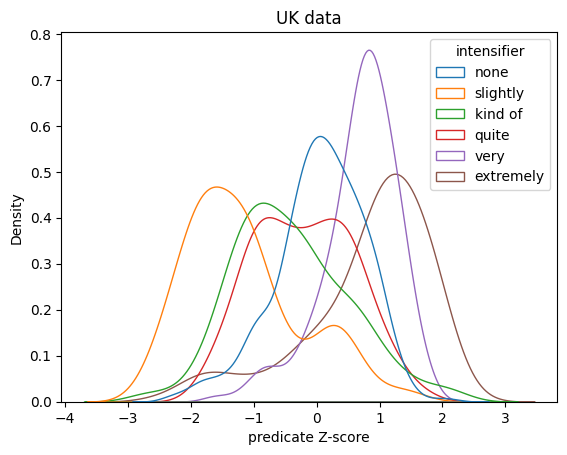

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(data=UK_dialogue,x="predicate Z-score", hue='intensifier',hue_order=  ['none','slightly','kind of','quite','very','extremely'], common_norm=False, fill=True,alpha = 0)
# title is UK data
plt.title("UK data")
print(min(UK_dialogue['predicate Z-score']), max(UK_dialogue['predicate Z-score']))

### trying similar CMA-ES algorithm but where we use raw threshold values and define bounds
- adjusted scaling for params of inf, soc so that varience of possible parameters is 1, around the same as threshold variance

In [17]:
import cma

@jax.jit
def state_prior(s):
    return np.exp(-s**2/2) # we assume s is roughly a gaussian distribution

@jax.jit
def UK_U_soc(intensifier,predicate):
    arr = np.array([
        [UK_U_soc_data[(w.name.replace('_'," "),p.name)] for p in P] 
        for w in W
    ])
    return arr[intensifier,predicate]
@jax.jit
def is_costly(w):
    arr = [0, 1, 1, 1, 1, 1]
    return np.array(arr)[w]

@jax.jit
def smooth_L(w, s,t0,t1,t2,t3,t4,t5,v0,v1, v2, v3, v4, v5):  # literal likelihood L(w | s)
    t = np.array([t0,t1,t2,t3,t4,t5])[w]
    v = np.array([v0,v1, v2, v3, v4, v5])[w]  # Variance parameters for each intensifier
    return np.exp(-(t-s)**2/v)

def smooth_wrapped_loss(x):
    result = smooth_UK_soc_logloss(*tuple(x))  # Unpack the parameters from the tuple
    return -result.item()


@memo
def smooth_UKL1[s: S, w: W](inf_term, soc_term, cost,t0,t1,t2,t3,t4,t5,v0,v1, v2, v3, v4, v5,p):
    listener: thinks[
        speaker: given(s in S, wpp=state_prior(s)),
        speaker: chooses(w in W, wpp=
            imagine[
                listener: knows(w),
                listener: chooses(s in S, wpp=smooth_L(w, s,t0,t1,t2,t3,t4,t5,v0, v1, v2, v3, v4, v5)), # L(w|s) = literal likelihood,
                exp(0.3*inf_term * log(Pr[listener.s == s]) + 
                0.5*soc_term * UK_U_soc(w,p) - # U_soc = listener's EU
                10*cost*is_costly(w)) # U_inf = listener's surprisal       
            ]
        )
    ]
    listener: observes[speaker.w] is w
    listener: chooses(s in S, wpp=Pr[speaker.s == s])
    return Pr[listener.s == s]

def smooth_UK_soc_logloss(*params):
    thetas = params[:6]
    cost = params[6]
    inf_term = params[7]
    soc_term = params[8]
    var = params[9:15]  # Extract the variance parameters
    P_l1 = np.concatenate([smooth_UKL1(inf_term=inf_term, soc_term=soc_term, cost=cost, t0 = thetas[0],t1=thetas[1], t2= thetas[2], t3 = thetas[3], t4 = thetas[4], t5 = thetas[5],v0 = var[0], v1=var[1], v2= var[2], v3 = var[3], v4 = var[4], v5 = var[5], p=p) for p in P],axis = 1)
    return np.sum(np.log(P_l1)*relevant_values)
best_params_list = []
best_values_list = []
for _ in range(20):
    # Get best solution
    es = cma.CMAEvolutionStrategy(
        [0.0] * 15,    # initial guess
        1, # sigma
        {"bounds": [[-3]*6+[None]*3+[0]*6, [3]*6+[None]*3+[None]*6],'tolfunhist': 1e-14,'tolflatfitness': 10,'tolfun': 1e-10},
    )
    es.optimize(smooth_wrapped_loss)
    best_params = es.result.xbest
    best_value = -es.result.fbest  # Negate to get the original loss value
    print(es.stop())
    print("Best value found:", best_value)
    print("Best parameters found:", best_params)
    best_params_list.append(best_params)
    best_values_list.append(best_value)

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 15 (seed=917618, Sat Apr  5 11:49:39 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 1.109549804687500e+04 1.0e+00 9.44e-01  9e-01  1e+00 0:00.3
    2     24 1.095679492187500e+04 1.1e+00 9.63e-01  9e-01  1e+00 0:00.3
    3     36 1.113222363281250e+04 1.2e+00 9.89e-01  9e-01  1e+00 0:00.4


  100   1200 1.084030859375000e+04 3.5e+00 1.18e-01  7e-02  1e-01 0:02.1


  200   2400 1.081896777343750e+04 1.3e+01 4.86e-02  2e-02  9e-02 0:03.8


  300   3600 1.080620703125000e+04 1.7e+01 2.03e-02  4e-03  3e-02 0:05.4


  400   4800 1.080560546875000e+04 4.1e+01 1.40e-02  1e-03  2e-02 0:07.5


  500   6000 1.080510351562500e+04 7.0e+01 9.83e-03  4e-04  1e-02 0:09.2


  600   7200 1.080491894531250e+04 1.3e+02 4.28e-03  9e-05  6e-03 0:10.9


  652   7824 1.080491406250000e+04 1.6e+02 2.06e-03  4e-05  3e-03 0:11.8
{'tolflatfitness': 10}
Best value found: -10804.912109375
Best parameters found: [ 0.24966552 -2.99999499 -0.49241625 -0.31368504  0.70382725  2.99998925
 -0.74292502  0.3833709   1.60856093  0.65097243  0.33750428  0.22167563
  0.17539625  0.13921752  0.51705557]
(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 15 (seed=936117, Sat Apr  5 11:49:52 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 1.125282617187500e+04 1.0e+00 8.99e-01  9e-01  9e-01 0:00.0
    2     24 1.099580175781250e+04 1.1e+00 8.82e-01  8e-01  9e-01 0:00.0
    3     36 1.123477343750000e+04 1.2e+00 8.47e-01  8e-01  9e-01 0:00.1


  100   1200 1.064772656250000e+04 5.0e+00 1.55e-01  7e-02  2e-01 0:01.6
  200   2400 1.062405566406250e+04 2.2e+01 2.21e-01  5e-02  4e-01 0:03.4
  300   3600 1.061705859375000e+04 4.5e+01 2.83e-02  4e-03  7e-02 0:05.0
  400   4800 1.061704687500000e+04 7.1e+01 1.78e-03  2e-04  5e-03 0:06.7
  449   5388 1.061704687500000e+04 5.9e+01 2.10e-03  2e-04  4e-03 0:07.5
{'tolfunhist': 1e-14}
Best value found: -10617.0458984375
Best parameters found: [-0.28914835 -1.82794621 -0.91576042 -0.60281223  0.45915287  1.04192212
  4.42728147  3.74756419  2.47976433  1.1473648   2.26899191  1.80360591
  1.3280221   1.10233249 12.58239242]
(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 15 (seed=948284, Sat Apr  5 11:50:01 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 1.111910253906250e+04 1.0e+00 9.30e-01  9e-01  9e-01 0:00.0
    2     24 1.111507812500000e+04 1.1e+00 8.70e-01  8e-01  9e-01 0:00.0
    3     36 1.115734960937500e+04 1.2e+00 8.46e-01  8e-01  

  100   1200 1.088614453125000e+04 4.9e+00 4.04e-01  2e-01  5e-01 0:01.8


  200   2400 1.084850585937500e+04 1.3e+01 1.89e-01  5e-02  2e-01 0:03.6


  300   3600 1.080826660156250e+04 1.4e+01 2.39e-02  4e-03  2e-02 0:05.4


  400   4800 1.080769726562500e+04 3.6e+01 4.77e-03  2e-04  5e-03 0:07.1


  500   6000 1.080764257812500e+04 1.5e+02 2.83e-03  3e-05  3e-03 0:08.7


  600   7200 1.080733886718750e+04 5.0e+02 1.22e-02  1e-04  3e-02 0:10.3


  638   7656 nan 4.7e+02 9.26e-03  8e-05  2e-02 0:10.9
{'tolflatfitness': 10}
Best value found: -10807.2978515625
Best parameters found: [ 1.60848502 -2.99999243 -0.53120156 -0.32637757  0.82551443  2.99940296
 -5.4542074   0.40668508  1.3564397   3.31375606  0.33753697  0.2603893
  0.20343687  0.14930905  0.5280795 ]
(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 15 (seed=943864, Sat Apr  5 11:50:13 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 1.105821875000000e+04 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     24 1.138772070312500e+04 1.2e+00 1.01e+00  1e+00  1e+00 0:00.0


    3     36 1.102517382812500e+04 1.3e+00 1.04e+00  1e+00  1e+00 0:00.0


  100   1200 1.062895117187500e+04 4.9e+00 1.34e-01  6e-02  1e-01 0:01.6
  200   2400 1.061786523437500e+04 2.5e+01 3.29e-02  7e-03  4e-02 0:03.2
  300   3600 1.061732226562500e+04 7.6e+01 6.15e-02  2e-02  1e-01 0:04.8
  400   4800 1.061706347656250e+04 8.9e+01 2.49e-02  3e-03  4e-02 0:06.4
  482   5784 1.061704687500000e+04 9.7e+01 3.93e-03  4e-04  7e-03 0:07.8
{'tolfunhist': 1e-14}
Best value found: -10617.046875
Best parameters found: [ 2.33805511  1.58683137  1.33309493  2.06591504 -1.8635235   0.07193269
  6.32675388 -2.56584621 -2.79361489  3.9566048   1.13340709  1.38787641
  2.33516745  4.8397137   0.7091474 ]
(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 15 (seed=935519, Sat Apr  5 11:50:22 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 1.110811914062500e+04 1.0e+00 8.91e-01  9e-01  9e-01 0:00.0
    2     24 1.119429980468750e+04 1.1e+00 8.78e-01  9e-01  9e-01 0:00.0
    3     36 1.110122753906250e+04 1.1e+00 8.80e-01  9e-01  9e-0

  100   1200 1.064454296875000e+04 1.1e+01 2.98e-01  8e-02  5e-01 0:01.6
  200   2400 1.062435351562500e+04 3.8e+01 1.90e-01  3e-02  5e-01 0:03.2
  300   3600 1.061706835937500e+04 5.1e+01 3.77e-02  4e-03  7e-02 0:04.8
  400   4800 1.061704687500000e+04 6.7e+01 3.11e-03  3e-04  5e-03 0:06.4
  500   6000 1.061704687500000e+04 7.6e+01 3.21e-03  4e-04  4e-03 0:08.0
  600   7200 1.061704687500000e+04 1.2e+02 1.84e-03  2e-04  2e-03 0:09.6
  700   8400 1.061704589843750e+04 1.5e+02 2.41e-03  2e-04  3e-03 0:11.3
  800   9600 1.061704687500000e+04 2.1e+02 1.31e-03  1e-04  2e-03 0:12.8
  900  10800 1.061704687500000e+04 2.6e+02 6.94e-04  5e-05  1e-03 0:14.5
 1000  12000 1.061704687500000e+04 4.3e+02 2.51e-04  2e-05  4e-04 0:16.1
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1080  12960 1.061704687500000e+04 4.6e+02 1.46e-04  9e-06  2e-04 0:17.4
{'tolstagnation': 579}
Best value found: -10617.044921875
Best parameters found: [-0.08839636 -1.24868331 -0.54290064 -0.3456

  100   1200 1.064988964843750e+04 4.1e+00 5.07e-01  3e-01  7e-01 0:01.8
  200   2400 1.061748046875000e+04 1.9e+01 9.32e-02  2e-02  2e-01 0:03.5
  300   3600 1.061706640625000e+04 8.4e+01 2.35e-02  5e-03  9e-02 0:05.2
  400   4800 1.061704687500000e+04 1.8e+02 6.84e-03  1e-03  3e-02 0:07.0
  500   6000 1.061704687500000e+04 2.1e+02 4.15e-03  8e-04  2e-02 0:09.1
  600   7200 1.061704687500000e+04 2.4e+02 3.74e-03  5e-04  1e-02 0:11.0
  627   7524 1.061704687500000e+04 2.3e+02 4.21e-03  6e-04  1e-02 0:11.5
{'tolfunhist': 1e-14}
Best value found: -10617.0458984375
Best parameters found: [ 2.88358676  1.7671539   1.57531298  2.42157791 -0.83132696  0.21269683
  3.06446719 -6.30695023 -1.74851924  8.93303965  2.71300681  3.32247138
  5.47364788 11.03774657  1.71740871]
(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 15 (seed=996846, Sat Apr  5 11:50:55 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 1.113212890625000e+04 1.0e+00 8.94e-01  9e-01  

  100   1200 1.082719140625000e+04 4.5e+00 8.16e-02  4e-02  9e-02 0:02.0


  200   2400 1.080765429687500e+04 9.3e+00 2.51e-02  6e-03  3e-02 0:03.9


  300   3600 1.080734082031250e+04 2.1e+01 5.03e-03  5e-04  7e-03 0:05.9


  350   4200 nan 3.2e+01 3.64e-03  2e-04  5e-03 0:06.8
{'tolflatfitness': 10}
Best value found: -10807.294921875
Best parameters found: [ 0.97852176 -2.9999677  -0.5709561  -0.34686305  0.80570464  2.99998288
 -2.12132815  0.41088063  1.26563088  3.24628397  0.33749649  0.26067517
  0.20511503  0.14856062  0.5415357 ]
(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 15 (seed=965578, Sat Apr  5 11:51:03 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 1.112263769531250e+04 1.0e+00 9.33e-01  9e-01  9e-01 0:00.0
{'tolfun': 1e-10}
Best value found: -11122.6376953125
Best parameters found: [ 1.21460233  0.25396112  0.1022301   1.30605656 -1.28870583  0.1729505
 -0.65932738  0.15055106 -0.75981505  0.17649167  0.27191815  0.26863223
  0.55420268  1.23638777  0.29146702]
(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 15 (seed=898486, Sat Apr  5 11:51:03 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 1.1107

  100   1200 1.062215429687500e+04 6.9e+00 1.66e-01  7e-02  2e-01 0:01.9
  200   2400 1.061791796875000e+04 2.3e+01 3.72e-02  7e-03  6e-02 0:03.8
  300   3600 1.061718750000000e+04 5.6e+01 2.13e-02  3e-03  4e-02 0:05.7
  400   4800 1.061704785156250e+04 9.5e+01 2.10e-02  4e-03  5e-02 0:07.4
  473   5676 1.061704687500000e+04 1.1e+02 5.19e-03  1e-03  1e-02 0:08.6
{'tolfunhist': 1e-14}
Best value found: -10617.046875
Best parameters found: [ 1.51623278  1.35180952  1.06097122  1.58635626 -2.47536489 -0.05635598
  3.9027659  -6.41115988 -1.95107941  9.26085312  2.77536094  3.39521764
  5.63319498 10.99581775  1.75249431]
(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 15 (seed=909220, Sat Apr  5 11:51:13 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 1.104717480468750e+04 1.0e+00 8.89e-01  9e-01  9e-01 0:00.0
    2     24 1.091344238281250e+04 1.1e+00 7.91e-01  8e-01  8e-01 0:00.0
    3     36 nan 1.1e+00 7.61e-01  7e-01  8e-01 0:00.1


  100   1200 1.062648242187500e+04 6.3e+00 1.31e-01  7e-02  2e-01 0:01.7
  200   2400 1.061336328125000e+04 2.5e+01 6.55e-02  1e-02  1e-01 0:03.4
  300   3600 1.061144238281250e+04 5.3e+01 3.54e-02  3e-03  9e-02 0:05.3
  400   4800 1.061130664062500e+04 8.8e+01 6.56e-03  5e-04  2e-02 0:07.0
  500   6000 1.061125976562500e+04 1.1e+02 1.63e-02  8e-04  4e-02 0:08.7
  600   7200 1.061120996093750e+04 2.6e+02 1.34e-02  6e-04  4e-02 0:10.4
  700   8400 1.061116406250000e+04 4.2e+02 1.99e-02  6e-04  8e-02 0:12.2
  800   9600 1.061114453125000e+04 4.6e+02 1.50e-02  2e-04  6e-02 0:13.9
  900  10800 1.061113769531250e+04 7.0e+02 5.25e-03  7e-05  2e-02 0:15.6
 1000  12000 1.061113867187500e+04 1.2e+03 3.03e-03  4e-05  1e-02 0:17.3
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1100  13200 1.061113671875000e+04 1.5e+03 5.01e-03  6e-05  2e-02 0:19.0
 1200  14400 1.061113671875000e+04 2.2e+03 4.31e-03  6e-05  2e-02 0:20.8
 1213  14556 1.061113671875000e+04 2.3e+03 6.23e-03 

  100   1200 1.062084082031250e+04 4.6e+00 2.22e-01  1e-01  3e-01 0:01.7
  200   2400 1.061746484375000e+04 2.5e+01 4.50e-02  1e-02  8e-02 0:03.4
  300   3600 1.061705664062500e+04 1.0e+02 2.42e-02  5e-03  1e-01 0:05.1
  382   4584 1.061704687500000e+04 1.7e+02 4.52e-03  8e-04  2e-02 0:06.6
{'tolfunhist': 1e-14}
Best value found: -10617.046875
Best parameters found: [ 2.79366059  1.65282193  1.39702457  2.27940868 -2.66868678  0.04829724
  4.0247973  -4.19983158 -2.44898831  8.24228974  1.98134255  2.46409625
  4.39524136 10.50338312  1.20873599]
(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 15 (seed=998040, Sat Apr  5 11:51:44 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 1.110644531250000e+04 1.0e+00 9.60e-01  9e-01  1e+00 0:00.0
    2     24 1.086467285156250e+04 1.1e+00 9.06e-01  9e-01  9e-01 0:00.0
    3     36 1.081507324218750e+04 1.2e+00 8.84e-01  9e-01  9e-01 0:00.1


  100   1200 1.064263671875000e+04 6.6e+00 1.24e-01  4e-02  2e-01 0:01.7
  200   2400 1.062056152343750e+04 2.9e+01 1.63e-01  3e-02  3e-01 0:03.5


  300   3600 1.061704882812500e+04 6.6e+01 9.54e-03  1e-03  2e-02 0:05.2


  400   4800 1.061704687500000e+04 1.0e+02 1.73e-03  2e-04  3e-03 0:06.9
  429   5148 1.061704687500000e+04 1.2e+02 1.08e-03  1e-04  2e-03 0:07.4
{'tolfunhist': 1e-14}
Best value found: -10617.0458984375
Best parameters found: [-0.05021826 -1.11471114 -0.46550059 -0.29338201  0.61641324  1.5942404
  5.48155449  9.38043612  1.59326049  2.57728941  4.62991407  3.82870301
  2.93897923  2.48588628 13.94174455]
(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 15 (seed=974751, Sat Apr  5 11:51:52 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 1.112687304687500e+04 1.0e+00 9.35e-01  9e-01  9e-01 0:00.0
    2     24 1.111355664062500e+04 1.1e+00 9.28e-01  9e-01  9e-01 0:00.0
    3     36 1.115995507812500e+04 1.2e+00 9.28e-01  9e-01  9e-01 0:00.1


  100   1200 1.064357812500000e+04 6.0e+00 1.90e-01  7e-02  3e-01 0:01.7
  200   2400 1.061711914062500e+04 1.8e+01 3.04e-02  6e-03  4e-02 0:03.5
  300   3600 1.061704687500000e+04 2.8e+01 2.66e-03  5e-04  4e-03 0:05.2
  378   4536 1.061704687500000e+04 3.8e+01 5.95e-04  9e-05  8e-04 0:06.6
{'tolfunhist': 1e-14}
Best value found: -10617.0458984375
Best parameters found: [-0.11895143 -1.29148423 -0.58454016 -0.37897579  0.56579621  1.4236929
  3.05183052  4.2432066   5.19104704  1.19553031  2.19470229  1.80082736
  1.36801916  1.15293028  7.28451836]
(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 15 (seed=971267, Sat Apr  5 11:52:00 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 1.109987207031250e+04 1.0e+00 9.18e-01  9e-01  9e-01 0:00.0
    2     24 1.151326464843750e+04 1.1e+00 8.87e-01  9e-01  9e-01 0:00.0
    3     36 1.098292578125000e+04 1.2e+00 8.43e-01  8e-01  9e-01 0:00.1


  100   1200 1.065703320312500e+04 4.7e+00 2.46e-01  9e-02  3e-01 0:01.7
  200   2400 1.062625390625000e+04 1.7e+01 8.54e-02  2e-02  1e-01 0:03.4
  300   3600 1.061718652343750e+04 2.8e+01 4.01e-02  6e-03  5e-02 0:05.3
  400   4800 1.061704687500000e+04 3.1e+01 2.16e-03  3e-04  2e-03 0:07.0
  500   6000 1.061704687500000e+04 3.8e+01 1.54e-03  2e-04  2e-03 0:08.7
  510   6120 1.061704687500000e+04 3.9e+01 1.48e-03  1e-04  2e-03 0:08.9
{'tolfunhist': 1e-14}
Best value found: -10617.0458984375
Best parameters found: [-0.34146789 -1.9362835  -1.00044181 -0.66373558  0.41119201  0.493774
  5.5488821   2.41897074 -4.34052024  0.74262302  1.4680016   1.17046092
  0.8599119   0.71523433  8.39844353]
(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 15 (seed=1002386, Sat Apr  5 11:52:10 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 1.110497460937500e+04 1.0e+00 9.67e-01  9e-01  1e+00 0:00.0
    2     24 1.114819628906250e+04 1.1e+00 1.01e+00  1e+00  1

  100   1200 1.090549414062500e+04 4.1e+00 4.69e-01  3e-01  5e-01 0:01.7


  200   2400 1.085886035156250e+04 1.3e+01 8.51e-02  2e-02  1e-01 0:03.5


  300   3600 1.085110156250000e+04 3.5e+01 1.06e-01  2e-02  2e-01 0:05.2


  400   4800 1.082740527343750e+04 4.5e+01 1.07e-01  2e-02  2e-01 0:06.9
  500   6000 1.081350585937500e+04 7.3e+01 6.45e-02  6e-03  1e-01 0:08.7


  600   7200 1.078295507812500e+04 1.1e+02 2.65e-02  2e-03  5e-02 0:10.4


  700   8400 1.078016406250000e+04 2.0e+02 2.63e-02  2e-03  7e-02 0:12.1


  800   9600 1.077695019531250e+04 3.5e+02 5.33e-02  1e-03  2e-01 0:13.8


  900  10800 1.077525781250000e+04 8.9e+02 2.47e-02  4e-04  9e-02 0:15.6


 1000  12000 1.077423437500000e+04 2.5e+03 3.57e-02  4e-04  2e-01 0:17.4
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]


 1100  13200 1.077372656250000e+04 2.4e+03 1.85e-02  2e-04  6e-02 0:19.2


 1200  14400 1.077349023437500e+04 5.3e+03 3.54e-02  2e-04  1e-01 0:20.9


 1300  15600 1.073969140625000e+04 4.0e+03 1.37e-01  8e-04  3e-01 0:22.6


 1400  16800 1.073781933593750e+04 1.8e+03 8.76e-02  7e-04  6e-02 0:24.4


 1500  18000 1.072515625000000e+04 2.6e+03 2.24e-01  2e-03  2e-01 0:26.1


 1600  19200 1.063871289062500e+04 2.5e+03 6.94e-01  5e-03  5e-01 0:27.8


 1700  20400 1.061819140625000e+04 2.1e+03 2.76e-01  2e-03  2e-01 0:29.5


 1800  21600 1.061646875000000e+04 1.3e+03 6.04e-02  3e-04  2e-02 0:31.2


 1853  22236 nan 1.5e+03 2.31e-02  1e-04  8e-03 0:32.1
{'tolflatfitness': 10}
Best value found: -10616.46484375
Best parameters found: [ 2.15860626  1.90819734  1.88791825  2.11433928  1.7060331   1.20241103
  0.89825313 -1.70628408  6.53214395  0.33730116  0.25161454  0.27116229
  0.30892775  0.34603075  0.21197541]
(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 15 (seed=986910, Sat Apr  5 11:52:47 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 1.103533984375000e+04 1.0e+00 9.30e-01  9e-01  9e-01 0:00.0
    2     24 1.112200781250000e+04 1.1e+00 8.91e-01  9e-01  9e-01 0:00.0
    3     36 1.111516210937500e+04 1.2e+00 8.77e-01  8e-01  9e-01 0:00.1


  100   1200 1.064189062500000e+04 8.6e+00 2.14e-01  6e-02  3e-01 0:01.7
  200   2400 1.061987890625000e+04 6.5e+01 2.79e-01  5e-02  1e+00 0:03.4
  300   3600 1.061234375000000e+04 5.0e+01 2.93e-02  4e-03  7e-02 0:05.1
  400   4800 1.061084765625000e+04 6.0e+01 2.13e-02  2e-03  4e-02 0:06.7
  500   6000 1.061063476562500e+04 1.5e+02 3.15e-02  2e-03  9e-02 0:08.4
  600   7200 1.061059765625000e+04 1.7e+02 3.55e-03  1e-04  1e-02 0:10.2
  639   7668 1.061059765625000e+04 1.9e+02 2.11e-03  9e-05  5e-03 0:10.8
{'tolfunhist': 1e-14}
Best value found: -10610.5966796875
Best parameters found: [-0.42161318 -2.20502313 -1.09981838 -0.74322197  0.23808877 -2.06574496
  0.52914667  2.15125088  0.45957452  0.56415966  1.38136346  0.94984172
  0.68952045  0.6442843  19.64666337]
(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 15 (seed=950957, Sat Apr  5 11:52:59 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 1.154001757812500e+04 1.0e+00 1.01e+00  1e+00  

  100   1200 1.062273339843750e+04 6.9e+00 1.34e-01  7e-02  2e-01 0:01.7
  200   2400 1.061810546875000e+04 2.7e+01 4.71e-02  1e-02  7e-02 0:03.4


  300   3600 1.061724804687500e+04 7.2e+01 3.57e-02  7e-03  7e-02 0:05.1


  400   4800 1.061705957031250e+04 1.3e+02 4.88e-02  1e-02  1e-01 0:06.7
  500   6000 1.061704687500000e+04 2.0e+02 4.03e-03  8e-04  1e-02 0:08.5
  600   7200 1.061704687500000e+04 2.6e+02 3.03e-03  5e-04  8e-03 0:10.1
  698   8376 1.061704687500000e+04 3.0e+02 1.66e-03  3e-04  4e-03 0:11.8
{'tolfunhist': 1e-14}
Best value found: -10617.0458984375
Best parameters found: [ 2.94902439  1.68144968  1.43540223  2.37314326 -2.65840896  0.06480568
  6.65940755 -3.30421493  0.07214706  6.58830892  1.56239668  1.94889995
  3.50559362  8.60438195  0.95284911]
(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 15 (seed=995037, Sat Apr  5 11:53:12 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 1.111676562500000e+04 1.0e+00 9.31e-01  9e-01  9e-01 0:00.0
    2     24 1.119631054687500e+04 1.1e+00 9.10e-01  9e-01  9e-01 0:00.0
    3     36 1.109800195312500e+04 1.2e+00 8.73e-01  8e-01  9e-01 0:00.1


  100   1200 1.062483984375000e+04 4.1e+00 1.43e-01  7e-02  2e-01 0:01.7
  200   2400 1.061845703125000e+04 1.9e+01 1.67e-02  4e-03  2e-02 0:03.7
  300   3600 1.061752148437500e+04 8.7e+01 7.95e-02  2e-02  2e-01 0:05.6
  400   4800 1.061712500000000e+04 1.0e+02 2.02e-02  3e-03  4e-02 0:07.4
  500   6000 1.061706835937500e+04 9.6e+01 2.81e-02  4e-03  5e-02 0:09.3
  600   7200 1.061704687500000e+04 1.3e+02 6.22e-03  6e-04  1e-02 0:11.0
  623   7476 1.061704687500000e+04 1.3e+02 8.95e-03  9e-04  2e-02 0:11.4
{'tolfunhist': 1e-14}
Best value found: -10617.046875
Best parameters found: [ 2.6925827   1.68130667  1.46717867  2.28252369 -1.5282414   0.12451167
  5.07272434 -3.07118547 -5.88341758  4.84936141  1.36616563  1.69104293
  2.84937885  5.93444179  0.85336282]
(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 15 (seed=1024988, Sat Apr  5 11:53:25 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 1.148527929687500e+04 1.0e+00 9.53e-01  9e-01  1e+

  100   1200 1.062614648437500e+04 6.0e+00 1.15e-01  5e-02  1e-01 0:01.8
  200   2400 1.061453906250000e+04 1.8e+01 4.64e-02  1e-02  7e-02 0:03.6
  300   3600 1.061072070312500e+04 3.4e+01 2.30e-02  4e-03  4e-02 0:05.3
  400   4800 1.061054882812500e+04 1.3e+02 5.08e-03  5e-04  2e-02 0:07.1
  500   6000 1.061054687500000e+04 2.0e+02 1.12e-03  9e-05  4e-03 0:08.9
  509   6108 1.061054687500000e+04 2.0e+02 6.70e-04  5e-05  2e-03 0:09.0
{'tolfunhist': 1e-14}
Best value found: -10610.5458984375
Best parameters found: [-0.33340399 -1.78646086 -0.89759396 -0.61497973  0.29857683  0.13067037
  0.5417322   1.23994984  0.49531865  0.30821653  0.69876618  0.49989988
  0.37186147  0.34882884  3.87190186]


[-10804.912109375, -10617.0458984375, -10807.2978515625, -10617.046875, -10617.044921875, -10617.0458984375, -10807.294921875, np.float64(-11122.6376953125), -10617.046875, -10611.13671875, -10617.046875, -10617.0458984375, -10617.0458984375, -10617.0458984375, -10616.46484375, -10610.5966796875, np.float64(-11540.017578125), -10617.0458984375, -10617.046875, -10610.5458984375]


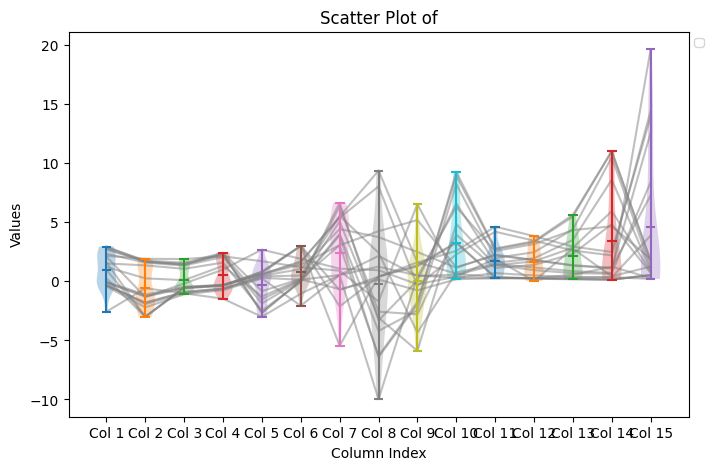

Best parameter 1: 0.9627 ± 1.4577
Best parameter 2: -0.5221 ± 1.7724
Best parameter 3: 0.0979 ± 1.0381
Best parameter 4: 0.5663 ± 1.3041
Best parameter 5: -0.3200 ± 1.5644
Best parameter 6: 0.8008 ± 1.2939
Best parameter 7: 2.3768 ± 3.1198
Best parameter 8: -0.2015 ± 4.6105
Best parameter 9: 0.0449 ± 2.8268
Best parameter 10: 3.2529 ± 3.0147
Best parameter 11: 1.7191 ± 1.2197
Best parameter 12: 1.6083 ± 1.2512
Best parameter 13: 2.1458 ± 1.7642
Best parameter 14: 3.3831 ± 3.8406
Best parameter 15: 4.6302 ± 5.8004


In [24]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 5))
x_positions = range(15)
print(best_values_list)
best_params_list = np.array(best_params_list)
best_params_list.at[:,14].set(best_params_list[:, 14]/5)
# best_params_list[:, 14] = best_params_list[:, 14] / 5  # Scale the last parameter by 5 as per the original code 
for point_idx in range(best_params_list.shape[0]):  # 10 points
    y_values = best_params_list[point_idx, :]  # All 9 values for that point
    plt.plot(x_positions, y_values, color='gray', alpha=0.5)

for i in range(15):  # Iterate over each column
    y_values = best_params_list[:, i]  # Extract 10 points from each column
    x_values = np.full(20, x_positions[i])  # Align x-values for scatter
    if i < 15:  # For the first 14 columns, plot scatter points
        plt.violinplot( y_values, positions=[x_positions[i]], showmeans=True, widths=0.5)
    # if i==14:
    #     plt.violinplot( y_values/5, positions=[x_positions[i]], showmeans=True, widths=0.5, showextrema=False)
# Labeling
plt.xlabel("Column Index")
plt.ylabel("Values")
plt.title(f"Scatter Plot of")
plt.xticks(x_positions, [f"Col {i+1}" for i in range(15)])  # Custom x-ticks

# plot legend on outside
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.show()
for i in range(15):
    print(f"Best parameter {i+1}: {best_params_list[:, i].mean():.4f} ± {best_params_list[:, i].std():.4f}")

In [26]:
print(best_params_list[1])

[-0.28914836 -1.8279462  -0.9157604  -0.60281223  0.45915288  1.0419221
  4.4272814   3.747564    2.4797642   1.1473649   2.268992    1.8036059
  1.3280221   1.1023325  12.582393  ]


Intensifier none: Mean = -0.2891, Variance = 1.1474, Std Dev = 1.0712
Intensifier slightly: Mean = -1.8279, Variance = 2.2690, Std Dev = 1.5063
Intensifier kind_of: Mean = -0.9158, Variance = 1.8036, Std Dev = 1.3430
Intensifier quite: Mean = -0.6028, Variance = 1.3280, Std Dev = 1.1524
Intensifier very: Mean = 0.4592, Variance = 1.1023, Std Dev = 1.0499
Intensifier extremely: Mean = 1.0419, Variance = 12.5824, Std Dev = 3.5472


Text(0.5, 1.0, 'Probability Distribution with Mean and Variance')

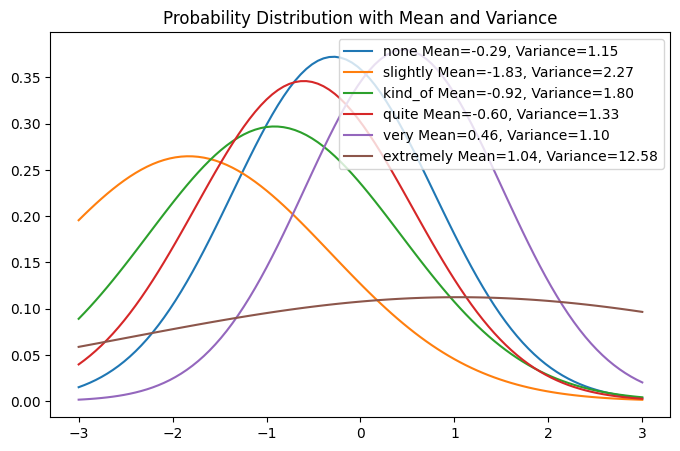

In [37]:
# plot graph of probablity distribution with mean -0.3 and variance 1.14
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
for i in range(6):
    mean = best_params_list[1, i].mean()
    variance = best_params_list[1, i + 9].mean()  # Assuming the variance is in the next 6 columns
    std_dev = np.sqrt(variance)
    print(f"Intensifier {W(i).name}: Mean = {mean:.4f}, Variance = {variance:.4f}, Std Dev = {std_dev:.4f}")
    x = np.linspace(-3, 3, 100)
    y = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)
    plt.plot(x, y, label=f'{W(i).name} Mean={mean :.2f}, Variance={variance:.2f}'.format(mean, variance))
plt.legend()
plt.title('Probability Distribution with Mean and Variance')